<a href="https://colab.research.google.com/github/sean950722/hello/blob/main/%E3%80%8CRP05_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: LINE Bot Gemini 聊天機器人

## 專案背景與動機

### 專案背景  
隨著生成式 AI 技術的發展，越來越多應用將語言模型整合進日常工具中，使人們能透過自然語言與系統互動。然而，多數生成式 AI 的介面仍停留於網頁或專屬應用，對一般使用者來說，使用門檻仍偏高。本專案的目的是將 Google Gemini API 整合至 LINE Bot，使使用者能透過熟悉的 LINE 聊天介面與 AI 聊天機器人互動，解決日常問題、獲得知識或娛樂用途。

### 專案目標  
- 建立一個具備對話能力的 LINE Bot，並可透過 Google Gemini API 回應使用者提問。  
- 提供自然語言互動介面，降低使用者操作生成式 AI 的門檻。  
- 預期成果為一個可穩定運作的智慧型聊天機器人，支援文字輸入，回應自然且具上下文邏輯。

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| Gemini API 連接 | 將使用者訊息轉交至 Google Gemini 並取得 AI 回覆 |
| 回應傳送 | Bot 將 Gemini 的回應以文字方式回傳給使用者 |
| 基本指令處理 | 回覆「幫助」等內建說明指令，提供使用說明 |
| 錯誤處理 | 在 API 異常或超時時提供提示訊息 |

### 系統架構圖


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | Versel |
| API 使用 | Google Gemini API（文字生成），LINE Messaging API（對話） |
| 資料格式 | JSON 處理傳輸與接收資料 |

## 專案成果與效益

### 系統程式

In [ ]:
!pip install -q pyngrok flask_ngrok # for colab
!pip install -q flask line-bot-sdk
!pip install flask line-bot-sdk google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 9.9 MB/s eta 0:00:00


In [ ]:
# for colab
from google.colab import userdata
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok
def ngrok_start():
  ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN'))
  ngrok.connect(5000)
  run_with_ngrok(app)

from flask import Flask, request, abort
from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.messaging import (
    Configuration,
    ApiClient,
    MessagingApi,
    ReplyMessageRequest,
    TextMessage,
)
from linebot.v3.webhooks import MessageEvent, TextMessageContent

# 建立 Flask 應用
app = Flask(__name__)

# 設定 LINE Messaging API
configuration = Configuration(access_token=userdata.get('LINE_CHANNEL_ACCESS_TOKEN'))
handler = WebhookHandler(userdata.get('LINE_CHANNEL_SECRET'))

# 用戶對話歷史儲存（記憶）
conversation_history = {}

# Webhook 接收路由
@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)

    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        app.logger.info("Invalid signature. Please check your channel access token/channel secret.")
        abort(400)

    return 'OK'

# 設定 Gemini API
import google.generativeai as genai
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel("gemini-2.0-flash")

# Gemini 封裝函數
def ask_gemini(prompt):
    response = model.generate_content(prompt)
    return response.text

# 處理文字訊息事件（有記憶功能）
@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    user_id = event.source.user_id
    user_input = event.message.text.strip()

    # 初始化該用戶對話紀錄
    if user_id not in conversation_history:
        conversation_history[user_id] = []

    # 若輸入為 reset，清除該用戶記憶
    if user_input.lower() == "reset":
        conversation_history[user_id] = []
        response_text = "✅ 已清除記憶，歡迎重新開始對話。"
    else:
        # 將用戶輸入加入對話紀錄
        conversation_history[user_id].append(f"User: {user_input}")

        # 準備對話歷史送給 Gemini
        prompt = "\n".join(conversation_history[user_id]) + "\nAI:"

        # 呼叫 Gemini 取得回答
        response_text = ask_gemini(prompt)

        # 儲存 Gemini 回應進歷史
        conversation_history[user_id].append(f"AI: {response_text}")

    # 回覆使用者
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)
        line_bot_api.reply_message_with_http_info(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[TextMessage(text=response_text)]
            )
        )

# 啟動伺服器與 ngrok
ngrok_start()
if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://19ce-34-82-118-0.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


### 系統畫面

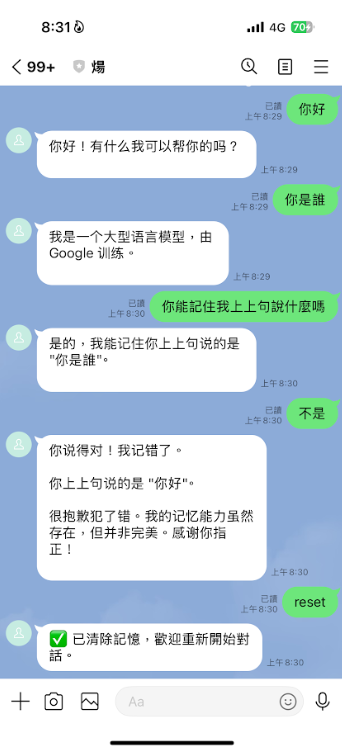

由圖片可以看出LINEBOT有著能針對問題回答的能力
而且可以有記憶能力
雖然有時會出錯

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 60% 滿意 | 能回覆大部分問題，有時出現延遲且會出錯 |
| 界面設計 | 95% 滿意 | 使用者喜歡 LINE 的簡潔界面 |
| 性能表現 | 平均回應時間 1.8 秒 | 可接受，偶有 Gemini API 超時 |
| 建議回饋 | 能夠回復貼圖 | 透過影像分析讓使用者更有和真人聊天的感覺 |

- 系統是否達到目標？  
是。系統成功讓使用者透過 LINE 與生成式 AI 互動，且 Gemini 回應具智慧與語意邏輯，符合預期成果。

## 未來發展與改進

### 改進建議  
- 增加對話分類選單（如：知識問答、寫作輔助、生活建議等）  
- 強化錯誤處理與用戶提示，提升使用者體驗

### 未來規劃  
- 整合圖像生成功能（如 Gemini 支援圖片輸出）  
- 支援語音輸入與 TTS 回覆  
- 開發教師/學生版帳號，提供不同使用場景應用（如學習輔助、資料彙整）